In [2]:
import os, sys
os.chdir("F:/01Algorithms/Hydrology/HAPI/Examples")
rootpath = os.path.abspath(os.getcwd())
# sys.path.append(rootpath + "/src")
datapath = os.path.join(rootpath, "data/GIS/Hapi_GIS_Data")
datapath2 = os.path.join(rootpath, "data/GIS")
os.chdir(rootpath)

from pyramids.raster import Raster
from pyramids.catchment import Catchment as GC
# from Hapi.visualizer import Visualize as vis
from digitalearth.map import Map
from osgeo import gdal
import numpy as np
import pandas as pd
import geopandas as gpd

## Paths

In [3]:
RasterAPath = datapath + "/acc4000.tif"
RasterBPath = datapath + "/dem_100_f.tif"
pointsPath = datapath + "/points.csv"
aligned_raster_folder = datapath + "/alligned_rasters/"
alligned_rasater = datapath + "/Evaporation_ECMWF_ERA-Interim_mm_daily_2009.01.01.tif"
soilmappath = datapath + "/soil_raster.tif"
Basinshp = datapath + "/basins.shp"

- you need to define the TEMP path in your environment variable as some of the metods in the raster module do some preprocessing in the TEMP path

- also if you have installed qgis define the directory to the bin folder inside the installation directory of qgis in the environment variable with a name "qgis"

#### 1- Read the raster:
- Read the raster using gdal

In [7]:
src = gdal.Open(RasterAPath)

#### 2- Plot the raster

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Flow Accumulation'}>)

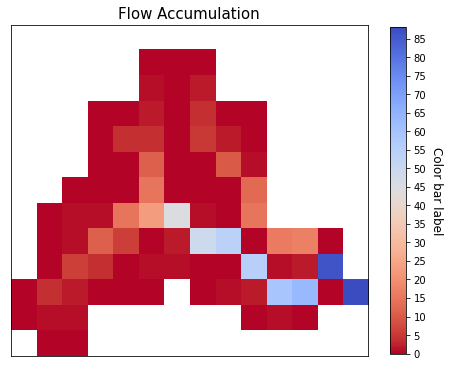

In [8]:
Map.plot(src, Title="Flow Accumulation")

#### 3- GetRasterData

- get the basic data inside a raster (the array and the nodatavalue)

Inputs:

    Input: [gdal.Dataset]
        a gdal.Dataset is a raster already been read using gdal
    band : [integer]
        the band you want to get its data. Default is 1
Outputs:

    1- mask:[array]
        array with all the values in the flow path length raster
    2- no_val: [numeric]
        value stored in novalue cells

In [12]:
arr, nodataval = Raster.getRasterData(src)
print(nodataval)

-3.402823e+38


#### 4- GetProjectionData

GetProjectionData returns the projection details of a given gdal.Dataset

Inputs:

    1- src : [gdal.Dataset]
        raster read by gdal

Returns:

    1- epsg : [integer]
         integer reference number to the new projection (https://epsg.io/)
        (default 3857 the reference no of WGS84 web mercator )
    2- geo : [tuple]
        geotransform data (minimum lon/x, pixelsize, rotation, maximum lat/y, rotation,
                            pixelsize). The default is ''.

In [18]:
epsg, geo = Raster.getProjectionData(src)
print("EPSG = " + str(epsg))
print("Coordinates of the upper left corner are")
print("X = " + str(geo[0]) + ", Y = " +  str(geo[3]))
print("Cell Size = " + str(geo[1]))

EPSG = 32618
Coordinates of the upper left corner are
X = 432968.1206170588, Y = 520007.787999178
Cell Size = 4000.0


#### 5- GetCoords

Returns the coordinates of the cell centres (only the cells that
does not have nodata value)

Parameters:


    dem : [gdal_Dataset]
        Get the data from the gdal datasetof the DEM

Returns:

    coords : array
        Array with a list of the coordinates to be interpolated, without the Nan
    mat_range : array
        Array with all the centres of cells in the domain of the DEM


In [ ]:
coords, centerscoords = Raster.getCellCoords(src)
print(coords)
print(centerscoords)

#### 6- SaveRaster

SaveRaster saves a raster to a path

inputs:

    1- raster:
        [gdal object]
    2- path:
        [string] a path includng the name of the raster and extention like
        path="data/cropped.tif"

Outputs:

    the function does not return and data but only save the raster to the hard drive

In [23]:
path = datapath + "/rasterexample.tif"
Raster.saveRaster(src,path)

#### 7- CreateRaster

CreateRaster method creates a raster from a given array and geotransform data
and save the tif file if a Path is given or it will return the gdal.Dataset

Parameters

    Path : [str], optional
        Path to save the Raster, if '' is given a memory raster will be returned. The default is ''.
    arr : [array], optional
        numpy array. The default is ''.
    geo : [list], optional
        geotransform list [minimum lon, pixelsize, rotation, maximum lat, rotation,
            pixelsize]. The default is ''.
    NoDataValue : TYPE, optional
        DESCRIPTION. The default is -9999.
    EPSG: [integer]
        integer reference number to the new projection (https://epsg.io/)
            (default 3857 the reference no of WGS84 web mercator )

Returns

    1- dst : [gdal.Dataset/save raster to drive].
                if a path is given the created raster will be saved to drive, if not
                a gdal.Dataset will be returned.
            
We will recreate the raster that we have already read using the 'GetRasterData' method at the 
top from the array and the projection data we obtained using the 'GetProjectionData' method


(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Flow Accumulation'}>)

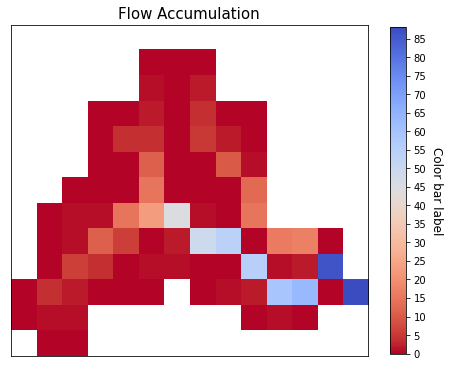

In [24]:
src = Raster.createRaster(arr=arr, geo=geo, epsg=str(epsg), nodatavalue=nodataval)
Map.plot(src, Title="Flow Accumulation")

#### 8- RasterLike

If we have made some calculation on raster array and we want to save the array back in the raster

RasterLike method creates a Geotiff raster like another input raster, new raster
will have the same projection, coordinates or the top left corner of the original
raster, cell size, nodata velue, and number of rows and columns
the raster and the dem should have the same number of columns and rows

inputs:

    1- src : [gdal.dataset]
        source raster to get the spatial information
    2- array:
        [numpy array]to store in the new raster
    3- path : [String]
        path to save the new raster including new raster name and extension (.tif)
    4- pixel_type : [integer]
        type of the data to be stored in the pixels,default is 1 (float32)
        for example pixel type of flow direction raster is unsigned integer
        1 for float32
        2 for float64
        3 for Unsigned integer 16
        4 for Unsigned integer 32
        5 for integer 16
        6 for integer 32

outputs:

    1- save the new raster to the given path
    

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Flow Accumulation'}>)

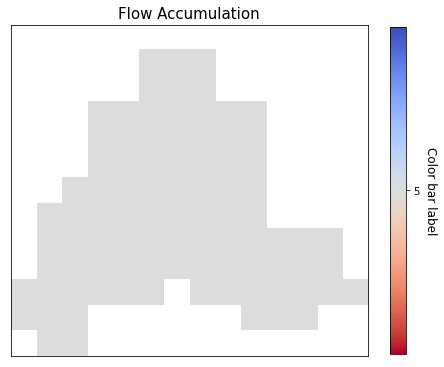

In [25]:
arr2 = np.ones(shape=arr.shape, dtype=np.float64) * nodataval
arr2[~ np.isclose(arr, nodataval, rtol=0.001)] = 5

path = datapath + "/rasterlike.tif"
Raster.rasterLike(src,arr2,path, )
dst = gdal.Open(path)
Map.plot(dst, Title="Flow Accumulation", ColorScale=1)

#### 9- MapAlgebra

MapAlgebra executes a mathematical operation on raster array and returns
the result

inputs:

    1-src : [gdal.dataset]
        source raster to that you want to make some calculation on its values
    3-function:
        defined function that takes one input which is the cell value
        

(<Figure size 576x576 with 2 Axes>, <AxesSubplot:title={'center':'Classes'}>)

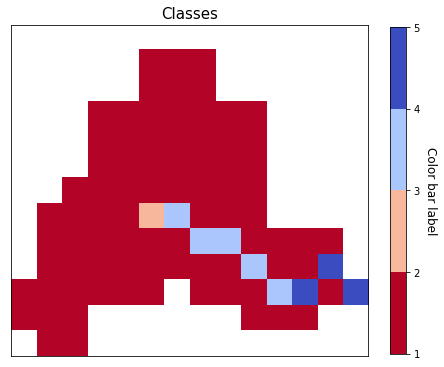

In [27]:
def func1(val):
    if val < 20 :
        val =  1
    elif val < 40 :
        val = 2
    elif val <  60 :
        val = 3
    elif val < 80 :
        val = 4
    elif val < 100 :
        val = 5
    else:
        val = 0
    return val
dst = Raster.mapAlgebra(src, func1)
Map.plot(dst, Title="Classes", ColorScale=4, TicksSpacing=1)

#### 10- RasterFill

RasterFill takes a raster and fill it with one value


inputs:

    1- src : [gdal.dataset]
        source raster
    2- Val: [numeric]
        numeric value
    3- SaveTo : [str]
        path including the extension (.tif)

Returns:

    1- raster : [saved on disk]
        the raster will be saved directly to the path you provided.

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Flow Accumulation'}>)

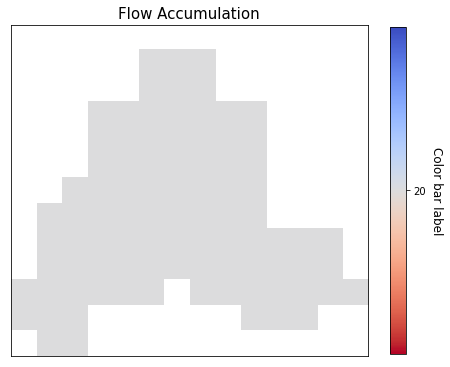

In [29]:
path = datapath + "/fillrasterexample.tif"
value = 20
Raster.rasterFill(src, value, SaveTo=path)

"now the resulted raster is saved to disk"
dst = gdal.Open(path)
Map.plot(dst, Title="Flow Accumulation")

#### 11-ResampleRaster

this function reproject a raster to any projection
(default the WGS84 web mercator projection, without resampling)
The function returns a GDAL in-memory file object, where you can ReadAsArray etc.

inputs:

    1- raster : [gdal.Dataset]
         gdal raster (src=gdal.Open("dem.tif"))
    3-cell_size : [integer]
         new cell size to resample the raster.
        (default empty so raster will not be resampled)
    4- resample_technique : [String]
        resampling technique default is "Nearest"
        https://gisgeography.com/raster-resampling/
        "Nearest" for nearest neighbour,"cubic" for cubic convolution,
        "bilinear" for bilinear

Outputs:

    1-raster : [gdal.Dataset]
         gdal object (you can read it by ReadAsArray)

Original Cell Size =4000.0
New cell size is 100.0


(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Flow Accumulation'}>)

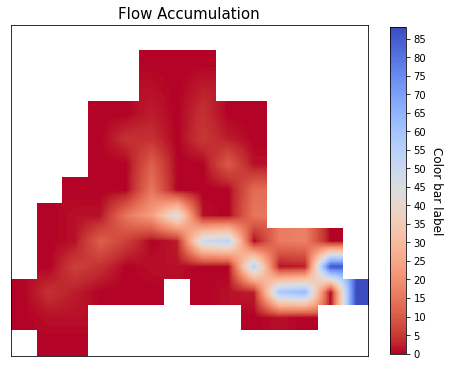

In [32]:
print("Original Cell Size =" + str(geo[1]))
cell_size = 100
dst = Raster.resampleRaster(src, cell_size, resample_technique="bilinear")

dst_arr,_ = Raster.getRasterData(dst)
_, newgeo = Raster.getProjectionData(dst)
print("New cell size is " + str(newgeo[1]))
Map.plot(dst, Title="Flow Accumulation")

#### 12-ProjectRaster

ProjectRaster reprojects a raster to any projection
(default the WGS84 web mercator projection, without resampling)
The function returns a GDAL in-memory file object, where you can ReadAsArray etc.

inputs:

    1- raster: [gdal object]
        gdal dataset (src=gdal.Open("dem.tif"))
    2-to_epsg: [integer]
        reference number to the new projection (https://epsg.io/)
        (default 3857 the reference no of WGS84 web mercator )
    3- resample_technique: [String]
        resampling technique default is "Nearest"
        https://gisgeography.com/raster-resampling/
        "Nearest" for nearest neighbour,"cubic" for cubic convolution,
        "bilinear" for bilinear
    4- Option : [1 or 2]


Outputs:

    1-raster:
        gdal dataset (you can read it by ReadAsArray)
        

In [34]:
print("current EPSG - " + str(epsg))
to_epsg = 4326
dst = Raster.projectRaster(src, to_epsg=to_epsg, option=1)
newepsg, newgeo = Raster.getProjectionData(dst)
print("New EPSG - " + str(newepsg))
print("New Geotransform - " + str(newgeo))
"""Option 2"""
print("Option 2")
dst = Raster.projectRaster(src, to_epsg=to_epsg, option=2)
newepsg, newgeo = Raster.getProjectionData(dst)
print("New EPSG - " + str(newepsg))
print("New Geotransform - " + str(newgeo))

current EPSG - 32618
New EPSG - 4326
New Geotransform - (-75.60441, 0.03606600000000526, 0.0, 4.704305, 0.0, -0.03606600000000526)
Option 2
New EPSG - 4326
New Geotransform - (-75.60441003848668, 0.03611587177268461, 0.0, 4.704560448076901, 0.0, -0.03611587177268461)


#### 13 - ReprojectDataset

ReprojectDataset reprojects and resamples a folder of rasters to any projection
(default the WGS84 web mercator projection, without resampling)
The function returns a GDAL in-memory file object, where you can ReadAsArray etc.

inputs:

    1- raster:
        gdal dataset (src=gdal.Open("dem.tif"))
    2-to_epsg:
        integer reference number to the new projection (https://epsg.io/)
        (default 3857 the reference no of WGS84 web mercator )
    3-cell_size:
        integer number to resample the raster cell size to a new cell size
        (default empty so raster will not be resampled)
    4- resample_technique:
        [String] resampling technique default is "Nearest"
        https://gisgeography.com/raster-resampling/
        "Nearest" for nearest neighbour,"cubic" for cubic convolution,
        "bilinear" for bilinear

Outputs:

    1-raster:
        gdal dataset (you can read it by ReadAsArray)
        